In [1]:
import numpy as np
import pandas as pd
import random 
import torch
import regex as re
from nltk.corpus import stopwords
from collections import Counter

from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer 
from collections import OrderedDict
from nltk.corpus import stopwords

from torch import nn
from torch.functional import F
from torch import optim
from tqdm import tqdm

In [33]:
remove_stopwords = True
use_lemmatization = True
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")

In [3]:
def tokenize_doc(sent,
                 lemma=False, 
                 remove_stopwords=False):
    
    # a simple tokenizer with case folding and an option to use lemmatization
    sent = sent.lower()
    tokens = sent.split()
    
    if lemma:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

def basic_text_processing(corpus, num_words):
    vocab = set()
    all_tokens = []
    
    # tokenization
    for doc in tqdm(corpus):
        tokens = tokenize_doc(doc, lemma=use_lemmatization, remove_stopwords=remove_stopwords)
        vocab.update(set(tokens))
        all_tokens.extend(tokens)
    
    # TODO START
    # We only want to train with the top num_words MOST FREQUENT words
    # Output a variable called ``train_tokens" that is similar to all_tokens
    # variable but without infrequent words
    freq_words = Counter(all_tokens)
    freq_words = sorted(freq_words, key=freq_words.get, reverse=True)
    train_tokens = [token for token in all_tokens if token in freq_words[:num_words]]
    # TODO END
    
    # generating vocabulary from the train_tokens
    word_counts = Counter(train_tokens)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) 
    i2w = {ii: word for ii, word in enumerate(sorted_vocab)}
    w2i = {word: ii for ii, word in i2w.items()}
    
    return  w2i, i2w, train_tokens

In [4]:
def get_targets(words, idx, window_size=5):
    R = random.randint(1, 5)
    start = max(0,idx-R)
    end = min(idx+R,len(words)-1)
    targets = words[start:idx] + words[idx+1:end+1] # +1 since doesn't include this idx
    return targets

In [5]:
def get_batches(words, batch_size, window_size = 5):
    for i in range(0, len(words), batch_size):
        curr = words[i:i + batch_size]   # current batch
        batch_x, batch_y = [], []
        
        for ii in range(len(curr)):
            x = [curr[ii]]
            y = get_targets(curr, ii)
            batch_x.extend(x * len(y))
            batch_y.extend(y)
        
        yield batch_x, batch_y

In [22]:
#CC-News dataset contains news articles from news sites all over the world. 
#The data is available on AWS S3 in the Common Crawl bucket at /crawl-data/CC-NEWS/. 
#This version of the dataset has been prepared using news-please - an integrated web crawler and information extractor for news.
#It contains 708241 English language news articles published between Jan 2017 and December 2019. 
#It represents a small portion of the English language subset of the CC-News dataset.

from datasets import load_dataset
dataset = load_dataset("cc_news")
corpus = dataset['train']['text'][:150000]


Found cached dataset cc_news (/home/nate/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6)


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# all configurations go here
# TODO
# You will need to set configurations below to a suitable values
# As for learning rate, the current value should work (but you are welcome to change it)
n_vocab = 10000  # maximum size of vocab
n_embed = 500 # size of embedding
lr = 0.003 # learning rate
n_negative_samples = 3 # number negative examples per positive example
ws = 5  # window size
batch_size =  500 # batch size for sampling positive examples
n_epochs =  10 #umber of training epochs
device = 'cpu'

In [23]:
# this cell might take 20 minutes to run, so be patient!
# optional: you might want to save these intermediate results to disk
# so that next time you open Google Colab, you don't need to
# run this again
w2i, i2w, train_tokens = basic_text_processing(corpus, num_words=n_vocab)
int_words = [w2i[token] for token in train_tokens]
print("Vocab Size:", len(w2i))

100%|███████████████████████████████████████| 1500/1500 [00:32<00:00, 46.10it/s]


Vocab Size: 1000


### Training

In [12]:
def train_skipgram(W,
                   C,
                   int_words,
                   n_vocab,
                   n_embed,
                   learning_rate,
                   n_negative_samples,
                   batch_size,
                   window_size,
                   n_epochs,
                   print_every=100):
    
    optimizer = optim.Adam([W, C], lr=learning_rate)    
    
    W = torch.nn.init.uniform_(W, -0.10, +0.10)
    C = torch.nn.init.uniform_(C, -0.10, +0.10)

    step = 0
    
    for epoch in range(n_epochs):
        for inputs, targets in get_batches(int_words, batch_size=batch_size, window_size=window_size):
            step += 1
            
            targets_indices = torch.LongTensor(inputs).to(device)
            contexts_indices = torch.LongTensor(targets).to(device)

            
            # retrieve vectors of target words and positive context words
            embeded_targets = W[targets_indices]
            embeded_pos_contexts = C[contexts_indices]
            
            batch_size, embed_size = embeded_targets.shape
           
            # retrieve vectors of negative examples
            noise_dist = torch.ones(n_vocab)
            noise_words = torch.multinomial(noise_dist, 
                                            num_samples=batch_size*n_negative_samples, 
                                            replacement=True)
            noise_words = noise_words.to(device)
            embed_neg_contexts = C[noise_words].view(batch_size, n_negative_samples, n_embed)
            
            #print(embeded_targets.shape)
            #print(embeded_pos_contexts.shape)
            #print(embed_neg_contexts.shape)
            # TODO START
            # calculating the final loss and output it to ``loss" variable
            embeded_targets = embeded_targets.view(batch_size,embed_size,1)
            embeded_pos_contexts = embeded_pos_contexts.view(batch_size,1, embed_size)
            
            pos_loss = torch.bmm(embeded_pos_contexts, embeded_targets).sigmoid().log().squeeze()
            neg_loss = torch.bmm(embed_neg_contexts.neg(), embeded_targets).sigmoid().log().squeeze().sum(1)
     
            
            loss = -(pos_loss + neg_loss).mean()
            # loss = 
            # TODO END
            
            
            # optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (step % print_every) == 0:
                print("Epoch: {}/{} | Loss: {:.4f}".format(epoch+1, n_epochs, loss.item()))

In [24]:
# initialization of W and C weight matrix
W = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))
C = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))

In [25]:
train_skipgram(W,
               C,
               int_words,
               n_vocab=n_vocab,
               n_embed=n_embed,
               learning_rate=lr,
               n_negative_samples=n_negative_samples,
               batch_size=batch_size,
               window_size=ws,
               n_epochs=n_epochs,
               print_every=100)

Epoch: 1/1 | Loss: 2.2502
Epoch: 1/1 | Loss: 2.1599
Epoch: 1/1 | Loss: 1.5530
Epoch: 1/1 | Loss: 1.8549
Epoch: 1/1 | Loss: 2.3393
Epoch: 1/1 | Loss: 2.3290
Epoch: 1/1 | Loss: 1.8296
Epoch: 1/1 | Loss: 1.9126
Epoch: 1/1 | Loss: 1.9745
Epoch: 1/1 | Loss: 1.9869
Epoch: 1/1 | Loss: 2.3110
Epoch: 1/1 | Loss: 2.0039
Epoch: 1/1 | Loss: 1.8050
Epoch: 1/1 | Loss: 1.7517
Epoch: 1/1 | Loss: 1.9609
Epoch: 1/1 | Loss: 1.8662
Epoch: 1/1 | Loss: 1.9285
Epoch: 1/1 | Loss: 2.1273
Epoch: 1/1 | Loss: 1.7211
Epoch: 1/1 | Loss: 1.5543
Epoch: 1/1 | Loss: 2.1162
Epoch: 1/1 | Loss: 1.9160
Epoch: 1/1 | Loss: 1.9261
Epoch: 1/1 | Loss: 2.0736
Epoch: 1/1 | Loss: 1.1461
Epoch: 1/1 | Loss: 1.2250
Epoch: 1/1 | Loss: 2.0574
Epoch: 1/1 | Loss: 2.2392
Epoch: 1/1 | Loss: 1.9857
Epoch: 1/1 | Loss: 1.9507
Epoch: 1/1 | Loss: 2.1122
Epoch: 1/1 | Loss: 1.6161
Epoch: 1/1 | Loss: 1.3538
Epoch: 1/1 | Loss: 1.3894
Epoch: 1/1 | Loss: 2.1179
Epoch: 1/1 | Loss: 1.9726
Epoch: 1/1 | Loss: 2.0501
Epoch: 1/1 | Loss: 2.0558
Epoch: 1/1 |

In [26]:
# final embeddings is the summation of the two matrix (check lecture slides)
embeddings = W.data.to('cpu').data.numpy()
embeddings += C.data.to('cpu').data.numpy()

### Evaluation via Visualization

/home/nate/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nate/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


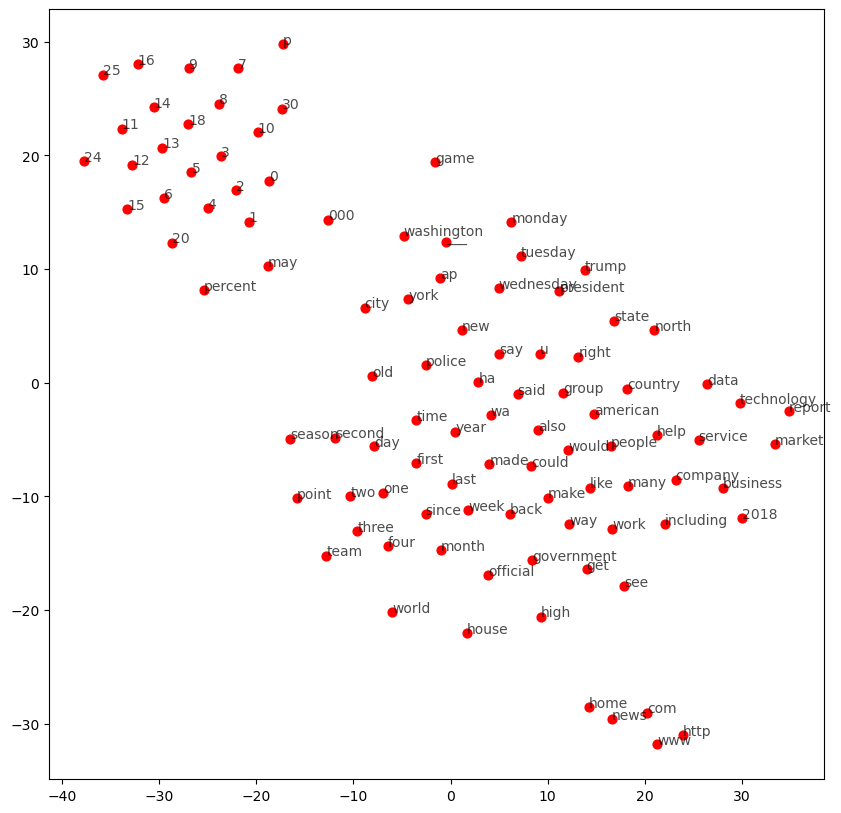

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_viz_words = 100
tsne = TSNE()
embeddings_tsne = tsne.fit_transform(embeddings[:n_viz_words, :])

fig, ax = plt.subplots(figsize = (10, 10))
for i in range(n_viz_words):
    plt.scatter(*embeddings_tsne[i, :], color = 'red', s=40)
    plt.annotate(i2w[i], (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), alpha = 0.7)

### Evaluation via Document Similarity

In [49]:
def transform(query, w2i, embeddings, strategy):
    # TODO
    # input: query or document, vocabulary w2i
    # input: trained word2vec embeddings
    # input: strategy: either 'average' or 'concatenate'
    # output: vector representation of the document query
    w2v_query = tokenize_doc(query, lemma=use_lemmatization, remove_stopwords=remove_stopwords)
    idx = [w2i[word] for word in w2v_query]
    v = [embeddings[i] for i in idx]
    
    assert strategy in ['average', 'concatenate']
    
    # get vectors of each word in the query
    
    # sentence aggregation strategy
    if strategy == 'average':
        # TODO START
        vector = [em.mean() for em in v]
        # vector = 
        # TODO END
    else:
        # TODO START
        vector = np.ravel(v)
        # TODO END
    
    return vector

In [34]:
# test document similarity
q = transform('today I am very happy', w2i, embeddings, strategy='average')
v = transform('today I feel so fascinated', w2i, embeddings, strategy='average')
sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
print("Cosine Similarity: {}".format(sim)) # this score should be high / close to 1.0

KeyError: 'happy'

In [19]:
def evaluation(strategy):
    df = pd.read_csv('./quora_train.csv')
    print("Loaded {} pairs".format(len(df)))
    pairs = list(zip(df['question1'].astype(str), df['question2'].astype(str)))
    
    all_sims = []
    
    for doc1, doc2 in tqdm(pairs):
        q = transform(doc1, w2i, embeddings, strategy=strategy)
        v = transform(doc2, w2i, embeddings, strategy=strategy)
        
        diff = len(q) - len(v)
        if diff > 0:
            v = np.pad(v, (0, np.abs(diff)))
        else:
            q = np.pad(q, (0, np.abs(diff)))
        
        sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
        all_sims.append(sim)
        
    return np.mean(all_sims)

In [20]:
avg_similarity = evaluation('average')
print("Final Average Similarity using Average Strategy: {}".format(avg_similarity))

Loaded 13000 pairs


  0%|                                                 | 0/13000 [00:00<?, ?it/s]


KeyError: 'overcome'

In [21]:
avg_similarity = evaluation('concatenate')
print("Final Average Similarity using Concatenation Strategy: {}".format(avg_similarity))

Loaded 13000 pairs


  0%|                                                 | 0/13000 [00:00<?, ?it/s]


KeyError: 'overcome'